In [1]:
import networkExpansionPy.lib as ne
import numpy as np
import pandas as pd
import pickle as pickle
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr,pearsonr,mannwhitneyu
from statsmodels.stats.multitest import multipletests
plt.rcParams['font.family'] = 'Arial'
from random import sample

import warnings
from scipy.sparse import (spdiags, SparseEfficiencyWarning, csc_matrix,
    csr_matrix, isspmatrix, dok_matrix, lil_matrix, bsr_matrix)
warnings.simplefilter('ignore',SparseEfficiencyWarning)

def load_data(network_name):
    with open(ne.asset_path  + "/metabolic_networks/" + network_name,"rb") as filehandler:
        metabolism = pickle.load(filehandler)
    return metabolism

# load the metabolism object from the repo
metabolism = load_data('metabolism.23Aug2022.pkl')
#model_id = "metabolism.v4.20Mar2023.pkl"
#model_id = "metabolism.v5.12Apr2023.pkl"
#metabolism = pd.read_pickle('/Users/joshuagoldford/Documents/github/network-expansion-assets/models/' + model_id)
cids = metabolism.coenzymes

In [2]:
nitrogen_sources = {
    "Ammonia": "C00014",
    "Nitrate": "C00244",
    "Nitrite": "C00088",
    "Glycine": "C00037",
    "Hydroxylamine": "C00192"}

sulfur_sources = {  
    "Sulfide": "C00283",
    "Sulfite": "C00094",
    "Sulfate": "C00059",
    "Thiosulfate": "C00320",
    "Sulfur dioxide":"C09306",
    "Elemental sulfur": "C00087"
}

inverted_nitrogen = {value: key for key, value in nitrogen_sources.items()}
inverted_sulfur = {value: key for key, value in sulfur_sources.items()}



dor = pd.read_csv("../assets/keggCHOmolecules.reductionState.csv")
cx = metabolism.network.cid.unique().tolist()
cx = [x for x in dor.cid.tolist() if x in cx]

def random_seed_set_generator(nitrogen_sources,sulfur_sources,carbon_sources,n_carb):
    n = sample(list(nitrogen_sources.values()),1)
    s = sample(list(sulfur_sources.values()),1)
    c = sample(carbon_sources,n_carb)
    return c+n+s

In [3]:
# (ii) randomize the seed set to control for state of reduction in organic compounds  
seed = pd.read_csv('../assets/seed_set.csv')
cpd_base = seed[~seed["Type"].isin(["Organic carbon","'Nitrogen source","Sulfur source"])].ID.tolist()
seedsets = [random_seed_set_generator(nitrogen_sources,sulfur_sources,cx,21) for x in range(1000)]
seed_inputs = [cpd_base + x for x in seedsets]

In [4]:
compounds,reactions = metabolism.run_expansions_parallel(seed_inputs,algorithm="naive")

In [9]:
#%%timeit -r 1 -n 1
#compounds2,reactions2 = metabolism.run_expansions(seed_inputs,algorithm="naive")

In [22]:
nitrogen = [inverted_nitrogen[[x for x in y if x in nitrogen_sources.values()][0]] for y in seedsets]
sulfur = [inverted_sulfur[[x for x in y if x in sulfur_sources.values()][0]] for y in seedsets]
mean_dor = [dor[dor.cid.isin(x)].reduction.mean() for x in seedsets]
ncpds = [len(x) for x in compounds]
df = pd.DataFrame({"nitrogen":nitrogen,"sulfur":sulfur,"dor":mean_dor,"ncpds":ncpds})

<AxesSubplot:xlabel='dor', ylabel='ncpds'>

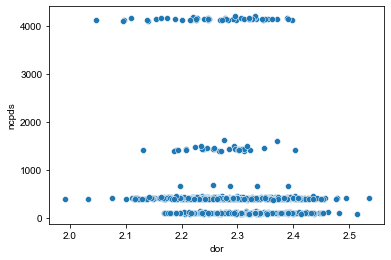

In [33]:
sns.scatterplot(x="dor",y="ncpds",data=df)

In [34]:
dor

,Unnamed: 0,cid,formula,name,num_rgroup,electrons,reduction,water_amt,water_per_c
0,21,C00022,C3H4O3,Pyruvate; Pyruvic acid; 2-Oxopropanoate; 2-Oxo...,0,46.0,1.666667,3.0,1.000000
1,25,C00026,C5H6O5,2-Oxoglutarate; Oxoglutaric acid; 2-Ketoglutar...,0,76.0,1.600000,5.0,1.000000
2,30,C00031,C6H12O6,D-Glucose; Grape sugar; Dextrose; Glucose; D-G...,0,96.0,2.000000,6.0,1.000000
3,32,C00033,C2H4O2,Acetate; Acetic acid; Ethanoic acid,0,32.0,2.000000,2.0,1.000000
4,35,C00036,C4H4O5,Oxaloacetate; Oxalacetic acid; Oxaloacetic aci...,0,68.0,1.250000,3.0,0.750000
...,...,...,...,...,...,...,...,...,...
5977,17371,C20899,C6H4O3,"Furan-2,5-dicarbaldehyde; 2,5-Furandicarboxald...",0,NaN,1.833333,9.0,1.500000
5978,17372,C20900,C6H6O4,5-(Dihydroxymethyl)furan-2-carbaldehyde,0,NaN,1.833333,8.0,1.333333
5979,17373,C20901,C6H6O5,5-(Dihydroxymethyl)furan-2-carboxylate,0,NaN,1.666667,7.0,1.166667
5980,17374,C20902,C6H10O5,"3,6-Anhydro-alpha-L-galactopyranose",0,NaN,2.000000,7.0,1.166667
